# ADC 2024 starter notebook 

This baseline notebook is designed to offer a starting point for the competiters. Please note that the approach we've taken is not *THE* solution — it's simply ONE possible approach. Our aim is to assist participants in exploring different ways to preprocess and model the data. Please feel free to fork the notebook and save the model/data for your own exploration.



This notebook was prepared by Virginie Batista and Angèle Syty from the Institut d'Astrophysique de Paris, and Orphée Faucoz from Centre National d’Etudes Spatiales (CNES), with support from Gordon Yip and Tara Tahseen from University College London.

# READ THIS BEFORE YOU PROCEED
This training procedure uses the light dataset produced from this [notebook (Version 5)](https://www.kaggle.com/code/gordonyip/update-calibrating-and-binning-astronomical-data). We applied all the calibration steps EXCEPT Linearity Correction with Chunksize = 1. The binned dataset is available to download [here](https://www.kaggle.com/datasets/gordonyip/binned-dataset-v3/data). *If you want to carry out all the correction, you will have to do so yourself.*


**This notebook will only provide the model checkpoints, you are welcomed to use these checkpoints with your own script and submit to the leaderboard.** 

## Task overview

The challenge's primary objective is to process these exposures to produce a single, clean spectrum for each exoplanet, summarizing the rp/rs values across all wavelengths.

The exposure are subject to noises and the images or spectrum are not perfect. The Jitter noise has a complex signature that the ML model should recognize to produce a better spectra.

Different techniques are possible and are up to the participant imagination to produce a novel (and hopefully better) solution to this task.

Here outline our baseline approach :

We first fit  a 1D CNN to fit the mean value of the transmission spectra, taking as input the transit white curve (total flux of each image taken as a function of time).

For the second part of the baseline, to retrieve the atmopsheric features, we make the data lighter by summing up the fluxes along the y-axis, for each wavelength, resulting in 2D images of dimension (N_times, N_wavelengths). We also cut the signal to remove the out of transit in order to enhance transit depth variations between wavelengths. For the same reason, we substract the mean flux, corresponding to the average transit depth, to keep only wavelength variations around this mean. We use a 2D CNN to fit the atmospheric features. 


In [1]:
import os
import random
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset

from torchinfo import summary

### Why Use $(R_p/R_s)^2$?
The label $(R_p/R_s)^2$ on the y-axis represents the **ratio of the planetary radius $R_p$ to the stellar radius $R_s$ squared**. This quantity is directly related to the **depth of the transit** in a light curve, which is essentially how much the observed stellar flux decreases as the planet transits (or passes in front of) its host star. In other words, $(R_p/R_s)^2$ corresponds to the fraction of the star's light that the planet blocks.

In this dataset:
- Each wavelength's data reflects **how the stellar flux changes at that wavelength during the transit**. This spectral data indicates which wavelengths experience different transit depths, influenced by the planet's atmosphere absorbing light at certain wavelengths more than others.
- The **observations (input data)** capture how flux varies across wavelengths, while the **targets (labels)** aim to model this variability.


In other words, the target should be to predict the variations in the flux ratios (caused by the planet's atmosphere).

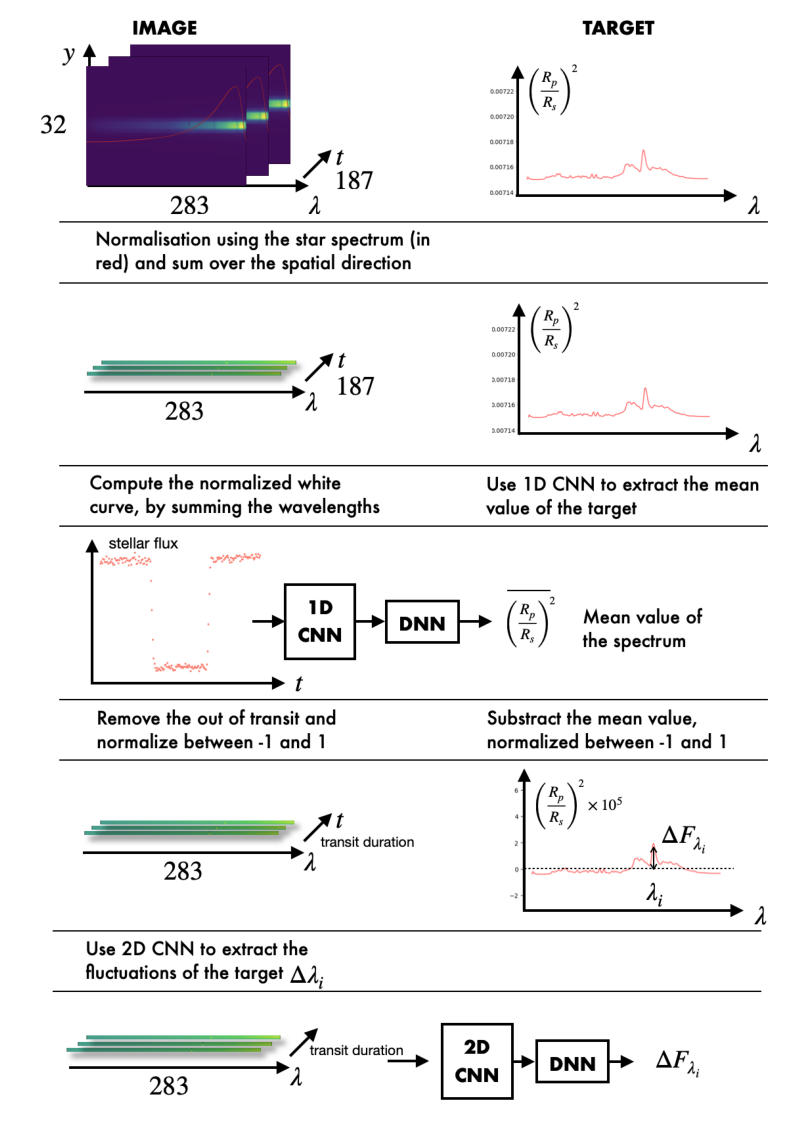

In [2]:
img = mpimg.imread("../dataset/baseline-img/2nd_baseline.png")
plt.figure(figsize=(10, 15))
plt.imshow(img)
plt.axis("off")
plt.show()

# Setup Paths and Read Data

In [3]:
# path to the folder containing the data
data_folder = "../dataset/binned-data/"

# path to the folder containing the train targets and wavelengths information
auxiliary_folder = "../dataset/ariel-data-challenge-2024/"

# output folder
output_dir = "../output"

# load the data
data_train = np.load(f"{data_folder}/data_train.npy")
data_train_FGS = np.load(f"{data_folder}/data_train_FGS.npy")
# data_train.shape: (673, 187, 282, 32)
# data_train_FGS.shape: (673, 187, 32, 32)

SEED = 42

do_the_mcdropout_wc = True
do_the_mcdropout = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# we have previously cut the data along the wavelengths to remove the edges, this is to match with the targets range in the make data file
cut_inf, cut_sup = (39, 321)
l = cut_sup - cut_inf + 1
wls = np.arange(l)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory {output_dir} created.")
else:
    print(f"Directory {output_dir} already exists.")

Directory ../output already exists.


# 1D-CNN for mean transit depth

## Preprocessing for 1D CNN

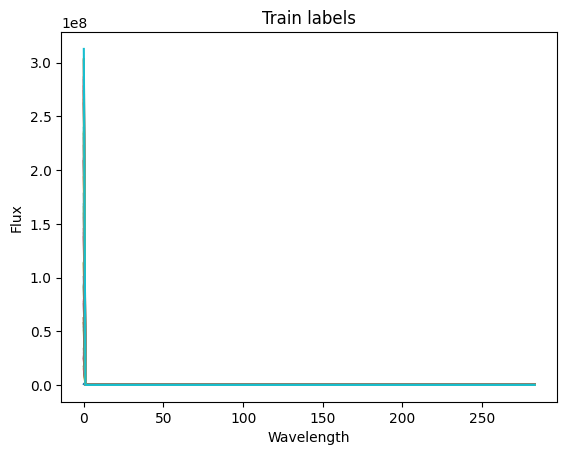

In [4]:
train_solution = np.loadtxt(
    f"{auxiliary_folder}/train_labels.csv", delimiter=",", skiprows=1
)

# targets:
# exclude the first column from the train_solution, because that column represents the baseline or overall flux
# which might not be needed when predicting the detailed wavelength-dependent features.
#
# The remaining length of 283 matches the length of one training sample label.
targets = train_solution[:, 1:]
# train_solution.shape: (673, 284)
# targets.shape: (673, 283)

for i in range(50):
    plt.plot(train_solution[i, :])

plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.title("Train labels")
plt.show()

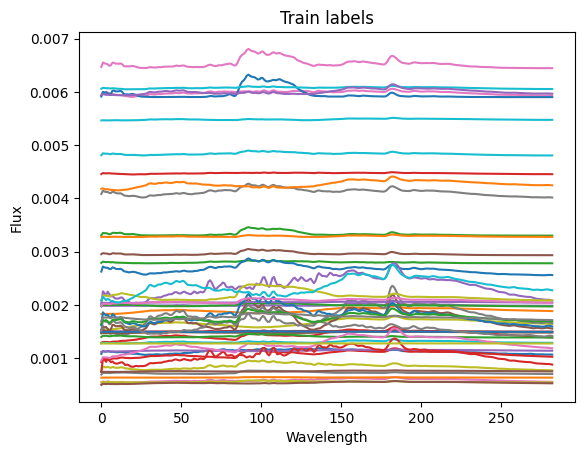

In [5]:
# targets_mean:
# The mean of the values in each wavelengths of `targets`, excluding the first column (FGS1)
# Used for the 1D-CNN to extract the mean value, only AIRS wavelengths as the FGS point is not used in the white curve
targets_mean = targets[:, 1:].mean(axis=1)
# targets_mean.shape: (673,)

N = targets.shape[0]

# plot targets
for i in range(50):
    plt.plot(targets[i, :])

plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.title("Train labels")
plt.show()

We create the dataset by adding the FGS frame, crushed in one column, at the end of the AIRS data cube.  
The images are normalized using the star spectrum extracted from the images themselves.

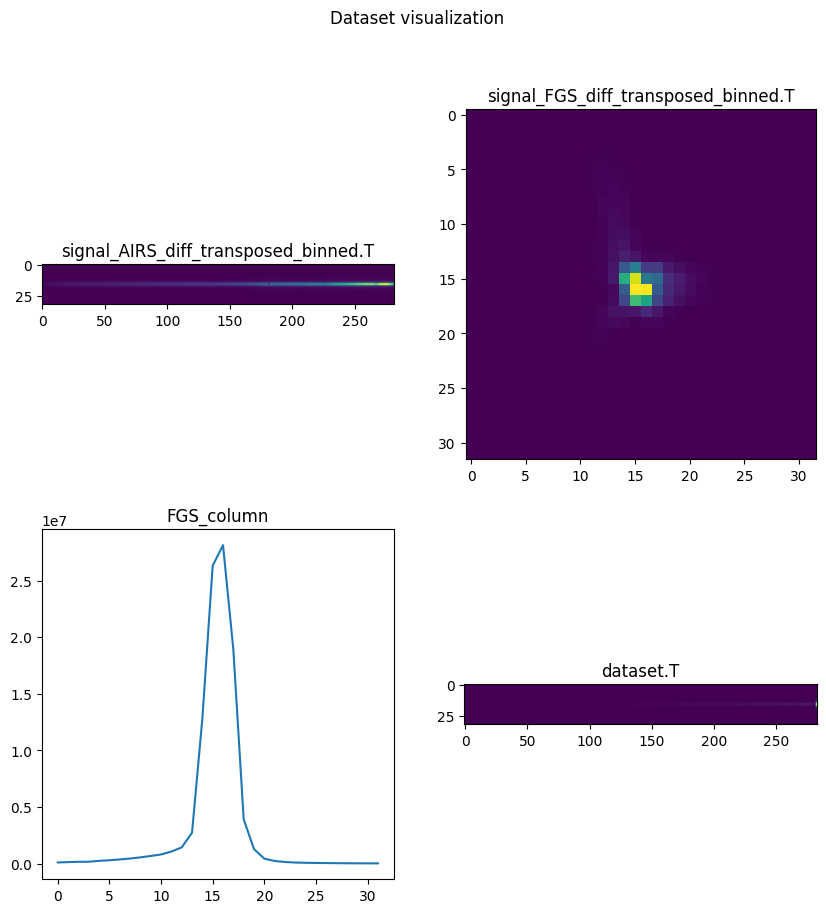

In [6]:
signal_AIRS_diff_transposed_binned, signal_FGS_diff_transposed_binned = (
    data_train,
    data_train_FGS,
)
# signal_AIRS_diff_transposed_binned.shape: (673, 187, 282, 32)
# signal_FGS_diff_transposed_binned.shape: (673, 187, 32, 32)

FGS_column = signal_FGS_diff_transposed_binned.sum(axis=2)
# FGS_column.shape: (673, 187, 32)

dataset = np.concatenate(
    [signal_AIRS_diff_transposed_binned, FGS_column[:, :, np.newaxis, :]], axis=2
)
# dataset.shape: (673, 187, 283, 32)

# plot
fig = plt.figure(figsize=(10, 10))
fig.suptitle("Dataset visualization")

ax1 = plt.subplot(2, 2, 1)
ax1.imshow(signal_AIRS_diff_transposed_binned[0, 0, :, :].T)
ax1.set_title("signal_AIRS_diff_transposed_binned.T")

ax2 = plt.subplot(2, 2, 2)
ax2.imshow(signal_FGS_diff_transposed_binned[0, 0, :, :].T)
ax2.set_title("signal_FGS_diff_transposed_binned.T")

# TODO: FGS_column has higher magnitude values
ax3 = plt.subplot(2, 2, 3)
ax3.plot(FGS_column[0, 0, :])
ax3.set_title("FGS_column")

ax4 = plt.subplot(2, 2, 4)
ax4.imshow(dataset[0, 0, :, :].T)
ax4.set_title("dataset.T")

# set figure size
plt.show()

we sum up the pixels on the y-axis to transform the data into 2D images

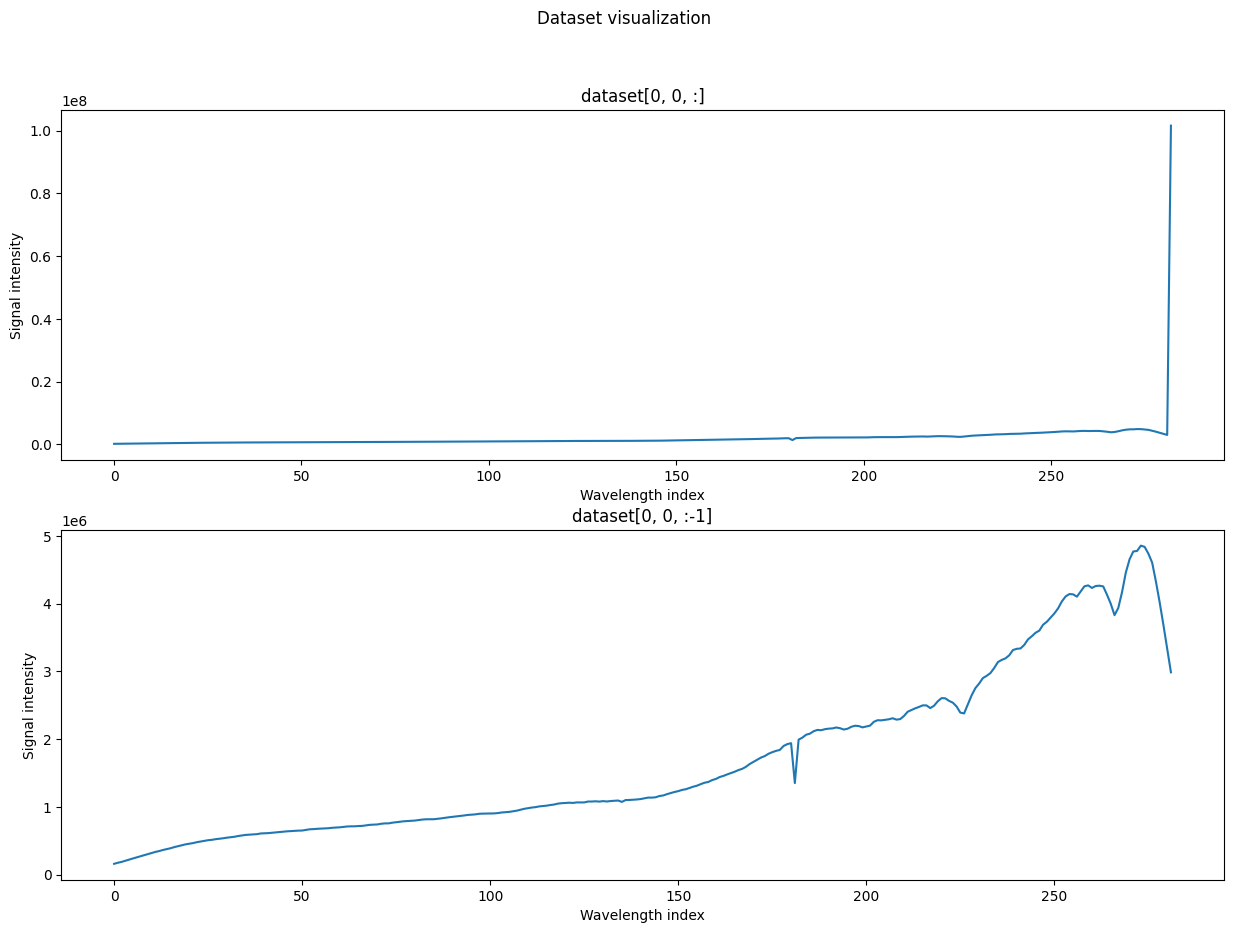

In [7]:
# squashing the the pixels dimension
dataset = dataset.sum(axis=3)
# dataset.shape: (673, 187, 283)

fig = plt.figure(figsize=(15, 10))
fig.suptitle("Dataset visualization")

ax1 = plt.subplot(2, 1, 1)
ax1.plot(dataset[0, 0, :])
ax1.set_title("dataset[0, 0, :]")
ax1.set_xlabel("Wavelength index")
ax1.set_ylabel("Signal intensity")

ax2 = plt.subplot(2, 1, 2)
ax2.plot(dataset[0, 0, :-1])
ax2.set_title("dataset[0, 0, :-1]")
ax2.set_xlabel("Wavelength index")
ax2.set_ylabel("Signal intensity")

plt.show()

We divide the images by the star flux assuming the first and last 50 instants belong to the out of transit. 

In [8]:
# TODO: this function is not used
def create_dataset_norm(dataset1, dataset2):
    dataset_norm1 = np.zeros(dataset1.shape)
    dataset_norm2 = np.zeros(dataset1.shape)
    dataset_min = dataset1.min()
    dataset_max = dataset1.max()
    dataset_norm1 = (dataset1 - dataset_min) / (dataset_max - dataset_min)
    dataset_norm2 = (dataset2 - dataset_min) / (dataset_max - dataset_min)
    return dataset_norm1, dataset_norm2


def norm_star_spectrum(signal):
    # This function assumes that the fist and last 50 time step bins belong to the out of transit
    #   1. Calculate the sum of the mean of the first and last 50 time step bins
    #   2. Normalize the all time step
    img_star = signal[:, :50].mean(axis=1) + signal[:, -50:].mean(axis=1)
    return signal / img_star[:, np.newaxis, :]


# dataset.shape: (673, 187, 283)
# total 673 number of observations, each with 187 time step bins and 283 wavelength total flux values
dataset_norm = norm_star_spectrum(dataset)
dataset_norm = np.transpose(dataset_norm, (0, 2, 1))
# dataset_norm.shape: (673, 283, 187)

## Split the targets and observations between valid and train

We start by computing a "white curve", that is actually the sum of the signal over the all image, as a function of time. We split the data and normalize the train/valid/test data.

In [9]:
def split(data, N):
    # TODO: set the seed
    random.seed(SEED)
    list_planets = random.sample(range(0, data.shape[0]), N)
    list_index_1 = np.zeros(data.shape[0], dtype=bool)
    for planet in list_planets:
        list_index_1[planet] = True
    data_1 = data[list_index_1]
    data_2 = data[~list_index_1]
    return data_1, data_2, list_index_1


# N = 673
N_train = 8 * N // 10

# Validation and train data split
train_obs, valid_obs, list_index_train = split(dataset_norm, N_train)
print("train_obs.shape", train_obs.shape)
print("valid_obs.shape", valid_obs.shape)
print("list_index_train.shape", list_index_train.shape)

train_obs.shape (538, 283, 187)
valid_obs.shape (135, 283, 187)
list_index_train.shape (673,)


train_wc.shape (538, 187)
valid_wc.shape (135, 187)
train_targets_wc_norm.shape (538,)
valid_targets_wc_norm.shape (135,)


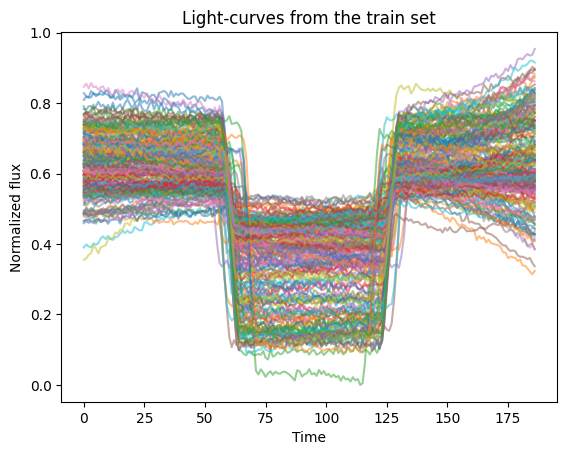

In [10]:
# signal_AIRS_diff_transposed_binned.shape: (673, 187, 282, 32)
signal_AIRS_diff_transposed_binned_sum3 = signal_AIRS_diff_transposed_binned.sum(axis=3)

# signal_AIRS_diff_transposed_binned_sum3.shape: (673, 187, 282)
wc_mean = signal_AIRS_diff_transposed_binned_sum3.mean(axis=1).mean(axis=1)
# wc_mean.shape: (673,) - mean of the white curve for each observation

# normalize the white curve
white_curve = (
    signal_AIRS_diff_transposed_binned_sum3.sum(axis=2) / wc_mean[:, np.newaxis]
)

del signal_AIRS_diff_transposed_binned_sum3, signal_AIRS_diff_transposed_binned


def normalise_wlc(train, valid):
    # normalise the training and validation data by scaling it into the range [0, 1]
    wlc_train_min = train.min()
    wlc_train_max = train.max()
    train_norm = (train - wlc_train_min) / (wlc_train_max - wlc_train_min)
    valid_norm = (valid - wlc_train_min) / (wlc_train_max - wlc_train_min)

    return train_norm, valid_norm


def normalize(train, valid):
    max_train = train.max()
    min_train = train.min()
    train_norm = (train - min_train) / (max_train - min_train)
    valid_norm = (valid - min_train) / (max_train - min_train)

    return train_norm, valid_norm, min_train, max_train


# Split the light curves and targets
train_wc, valid_wc = white_curve[list_index_train], white_curve[~list_index_train]
train_targets_wc, valid_targets_wc = (
    targets_mean[list_index_train],
    targets_mean[~list_index_train],
)

# Normalize the wlc
train_wc, valid_wc = normalise_wlc(train_wc, valid_wc)

# Normalize the targets
train_targets_wc_norm, valid_targets_wc_norm, min_train_valid_wc, max_train_valid_wc = (
    normalize(train_targets_wc, valid_targets_wc)
)

print("train_wc.shape", train_wc.shape)
print("valid_wc.shape", valid_wc.shape)
print("train_targets_wc_norm.shape", train_targets_wc_norm.shape)
print("valid_targets_wc_norm.shape", valid_targets_wc_norm.shape)

# plot train_wc
plt.figure()
for i in range(200):
    plt.plot(train_wc[-i], "-", alpha=0.5)
plt.title("Light-curves from the train set")
plt.xlabel("Time")
plt.ylabel("Normalized flux")
plt.show()

## Train 1D CNN

The model to estimate the mean of the target spectrum using the white light-curve is a 1D-CNN with Dropout layers to make a MC Dropout prediction.

This 1D CNN model is designed to predict the **mean flux** values across all 282 wavelengths, as represented by targets_mean for each observation, using the white curve as input data.

### Input: White Curve (673, 187)

The white curve provides a normalized temporal profile of the flux signal for each observation (673 observations in total), aggregated over spatial dimensions and wavelengths.

This temporal profile across 187 time steps serves as the input feature for each observation, focusing the model on how the flux changes over time while minimizing spectral details.


### Output: Targets Mean (673,)

The model aims to predict the mean flux across specific wavelengths (283 in total) for each observation, as captured in targets_mean.

This mean flux is computed from the targets matrix, which excludes the first column in the train_solution data. The first column likely represents a baseline flux measurement, while the remaining columns represent wavelength-specific flux measurements.

The target is thus an overall "mean" value that characterizes each observation’s flux level across these wavelengths.


### Purpose of the 1D CNN:

The 1D CNN is structured to capture patterns in the temporal signal of the white curve that correlate with the overall flux level across wavelengths.

By predicting the mean flux, the model may indirectly capture factors such as instrument calibration effects, environmental factors, or baseline shifts that impact the overall light intensity at a given observation time.

This prediction provides an efficient summary statistic, allowing scientists to quickly assess the average flux across wavelengths for each observation without needing to reconstruct the full wavelength-dependent signal.


### Why Mean Flux Prediction is Useful
Predicting the mean flux is beneficial because it:

- Reduces dimensionality from detailed spectral features to a single summary metric.
- Provides a normalized measure of light intensity across time for further analyses or comparisons.
- Can be used as a preliminary step in a more complex analysis pipeline, where the mean flux serves as an input feature or control variable.

In [11]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Define the convolutional layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3)

        # Define pooling and batch normalization layers
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.bn1 = nn.BatchNorm1d(num_features=32)

        # Define fully connected layers
        self.fc1 = nn.Linear(in_features=256 * 9, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=100)
        self.fc3 = nn.Linear(in_features=100, out_features=1)

        # Flatten layer
        self.flatten = nn.Flatten()

        # Dropout
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.bn1(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)

        x = F.relu(self.conv4(x))
        x = self.pool(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        x = self.fc3(x)
        return x


# Checkpoint saving function
def save_checkpoint(model, valid_loss, best_valid_loss, epoch, optimizer, output_dir):

    if valid_loss < best_valid_loss:

        print(
            f"Validation loss decreased from {best_valid_loss:.6f} to {valid_loss:.6f}."
        )

        best_valid_loss = valid_loss
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": valid_loss,
            },
            output_dir + "/model_1d_cnn.pth",
        )

    return best_valid_loss


# Checkpoint loading function
def load_checkpoint(model_dir, model, optimizer):
    model_path = model_dir + "/model_1d_cnn.pth"

    if not os.path.exists(model_path):
        print("Checkpoint file does not exist. Training from scratch.")
        return model, optimizer, 0, float("inf")

    # Load the saved checkpoint
    checkpoint = torch.load(model_path, weights_only=False)

    # Restore model state
    model.load_state_dict(checkpoint["model_state_dict"])

    # Restore optimizer state
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    # Retrieve the epoch and loss information
    epoch = checkpoint["epoch"]
    valid_loss = checkpoint["loss"]

    print(f"Checkpoint loaded: Epoch {epoch}, Validation Loss {valid_loss:.4f}")

    return model, optimizer, epoch, valid_loss


# Training Loop
def train(
    model,
    train_loader,
    valid_loader,
    num_epochs,
    criterion,
    optimizer,
    scheduler,
    output_dir,
    device,
    best_valid_loss=float("inf"),
):
    print("Training started.")

    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        # 1. Training phase
        model.train()
        running_loss = 0.0

        train_progress = tqdm(train_loader)
        for x_train, y_train in train_progress:

            x_train, y_train = x_train.to(device), y_train.to(device)

            optimizer.zero_grad()

            # Forward pass
            output = model(x_train)
            loss = criterion(output, y_train)

            # Backward pass
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            train_progress.set_description(f"Epoch {epoch+1}/{num_epochs}")
            train_progress.set_postfix({"loss": loss.item()})

        # Learning rate decay
        if scheduler is not None:
            scheduler.step()

        # Average training loss for the epoch
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # 2. Validation phase
        model.eval()
        valid_loss = 0.0

        with torch.no_grad():
            valid_progress = tqdm(valid_loader)
            for x_valid, y_valid in valid_progress:

                x_valid, y_valid = x_valid.to(device), y_valid.to(device)

                valid_output = model(x_valid)
                valid_loss += criterion(valid_output, y_valid).item()

                valid_progress.set_description(
                    f"Validation Epoch {epoch+1}/{num_epochs}"
                )
                valid_progress.set_postfix(
                    {"valid_loss": valid_loss / len(valid_loader)}
                )

        # Average validation loss
        avg_valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)

        # Save the best model checkpoint
        best_valid_loss = save_checkpoint(
            model, avg_valid_loss, best_valid_loss, epoch, optimizer, output_dir
        )

    print("Training completed.")

    # Save all train_losses and valid_losses of this training process
    np.save(output_dir + "/train_losses.npy", train_losses)
    np.save(output_dir + "/valid_losses.npy", valid_losses)

    return train_losses, valid_losses

Creating DataLoader for wc training and validation data

In [12]:
# define model hyperparameters
num_epochs = 1200
batch_size = 16


model = CNNModel().to(device)


optimizer = optim.SGD(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=200, gamma=0.2)


loss_fn = torch.nn.MSELoss()


best_valid_loss = float("inf")


# compare input data with Tensorflow data
def compare_tf_data_with_current_data(torch_data, tf_data, str=""):
    print(str, ": ", np.array_equal(torch_data, tf_data))


compare_tf_data_with_current_data(
    train_wc, np.load("../output/data_tf/train_wc.npy"), "train_wc"
)
compare_tf_data_with_current_data(
    train_targets_wc_norm,
    np.load("../output/data_tf/train_targets_wc_norm.npy"),
    "train_targets_wc_norm",
)
compare_tf_data_with_current_data(
    valid_wc, np.load("../output/data_tf/valid_wc.npy"), "valid_wc"
)
compare_tf_data_with_current_data(
    valid_targets_wc_norm,
    np.load("../output/data_tf/valid_targets_wc_norm.npy"),
    "valid_targets_wc_norm",
)

# Create TensorDataset for training and validation data
train_dataset = TensorDataset(
    torch.tensor(train_wc[:, np.newaxis, :], dtype=torch.float32),
    torch.tensor(train_targets_wc_norm[:, np.newaxis], dtype=torch.float32),
)
valid_dataset = TensorDataset(
    torch.tensor(valid_wc[:, np.newaxis, :], dtype=torch.float32),
    torch.tensor(valid_targets_wc_norm[:, np.newaxis], dtype=torch.float32),
)

# Create DataLoader for training and validation data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

print("train input: ", train_loader.dataset.tensors[0].shape)
print("train output: ", train_loader.dataset.tensors[1].shape)
print("valid input: ", valid_loader.dataset.tensors[0].shape)
print("valid output: ", valid_loader.dataset.tensors[1].shape)

summary(model, input_size=(train_loader.dataset.tensors[0].shape))

train_wc :  True
train_targets_wc_norm :  True
valid_wc :  True
valid_targets_wc_norm :  True
train input:  torch.Size([538, 1, 187])
train output:  torch.Size([538, 1])
valid input:  torch.Size([135, 1, 187])
valid output:  torch.Size([135, 1])


Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [538, 1]                  --
├─Conv1d: 1-1                            [538, 32, 185]            128
├─MaxPool1d: 1-2                         [538, 32, 92]             --
├─BatchNorm1d: 1-3                       [538, 32, 92]             64
├─Conv1d: 1-4                            [538, 64, 90]             6,208
├─MaxPool1d: 1-5                         [538, 64, 45]             --
├─Conv1d: 1-6                            [538, 128, 43]            24,704
├─MaxPool1d: 1-7                         [538, 128, 21]            --
├─Conv1d: 1-8                            [538, 256, 19]            98,560
├─MaxPool1d: 1-9                         [538, 256, 9]             --
├─Flatten: 1-10                          [538, 2304]               --
├─Linear: 1-11                           [538, 500]                1,152,500
├─Dropout: 1-12                          [538, 500]               

In [ ]:
train_losses, valid_losses = train(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    num_epochs=num_epochs,
    criterion=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    output_dir=output_dir,
    device=device,
    best_valid_loss=best_valid_loss,
)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), valid_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig(output_dir + "/training_validation_loss.png")
plt.show()

In [13]:
model, optimizer, epoch, best_valid_loss = load_checkpoint(output_dir, model, optimizer)

Checkpoint loaded: Epoch 1105, Validation Loss 0.0005


## 1D CNN Inference

Then, we perform the MC Dropout to obtain the mean prediction and the uncertainty associated. We choose to compute 1000 instances.

In [14]:
nb_dropout_wc = 1000


def unstandardizing(data, min_train_valid, max_train_valid):
    return data * (max_train_valid - min_train_valid) + min_train_valid


def MC_dropout_WC(model, data_loader, nb_dropout, device):
    """
    Monte Carlo dropout is used to estimate the uncertainty of the model's predictions
    by performing multiple forward passes with dropout enabled.

    """
    model.eval()
    all_predictions = []

    for _ in range(nb_dropout):
        predictions = []

        with torch.no_grad():  # Disable gradient computation
            for x_valid, _ in data_loader:

                x_valid = x_valid.to(device)

                # Forward pass
                output = model(x_valid)
                predictions.append(output.cpu().numpy().flatten())
                # length of predictions: 135 (number of validation samples)

        # Stack predictions for this dropout run and append to all_predictions
        all_predictions.append(np.concatenate(predictions, axis=0))

    return np.array(all_predictions)


if do_the_mcdropout_wc:
    print("Running ...")

    prediction_valid_wc = MC_dropout_WC(model, valid_loader, nb_dropout_wc, device)
    spectre_valid_wc_all = unstandardizing(
        prediction_valid_wc, min_train_valid_wc, max_train_valid_wc
    )

    spectre_valid_wc = spectre_valid_wc_all.mean(axis=0)
    spectre_valid_std_wc = spectre_valid_wc_all.std(axis=0)

    print("Done.")

    print("prediction_valid_wc.shape", prediction_valid_wc.shape)
    print("spectre_valid_wc_all.shape", spectre_valid_wc_all.shape)
    print("spectre_valid_wc.shape", spectre_valid_wc.shape)
    print("spectre_valid_std_wc.shape", spectre_valid_std_wc.shape)

Running ...
Done.
prediction_valid_wc.shape (1000, 135)
spectre_valid_wc_all.shape (1000, 135)
spectre_valid_wc.shape (135,)
spectre_valid_std_wc.shape (135,)


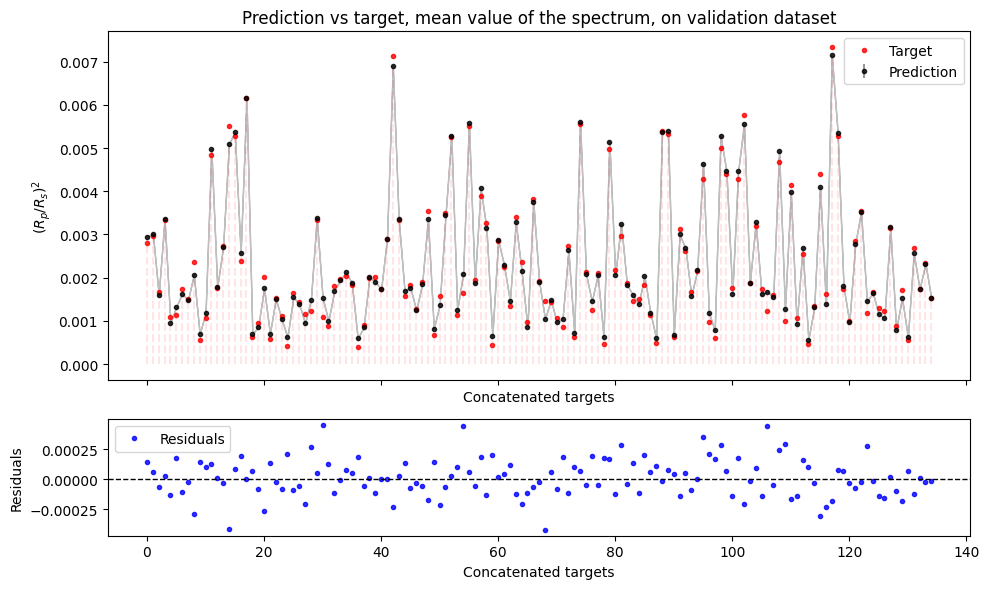

In [15]:
residuals = spectre_valid_wc - valid_targets_wc
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10, 6), sharex=True, gridspec_kw={"height_ratios": [3, 1]}
)

ax1.errorbar(
    x=np.arange(len(spectre_valid_wc)),
    y=spectre_valid_wc,
    yerr=spectre_valid_std_wc,
    fmt=".",
    color="k",
    ecolor="gray",
    label="Prediction",
    alpha=0.8,
)
ax1.fill_between(
    np.arange(len(spectre_valid_wc)),
    spectre_valid_wc - spectre_valid_std_wc,
    spectre_valid_wc + spectre_valid_std_wc,
    color="grey",
    alpha=0.5,
)
ax1.vlines(
    np.arange(len(spectre_valid_wc)),
    ymin=0,
    ymax=spectre_valid_wc,
    colors="r",
    linestyle="dashed",
    alpha=0.1,
)
ax1.plot(valid_targets_wc, "r.", label="Target", alpha=0.8)
ax1.set_xlabel("Concatenated targets")
ax1.set_ylabel("$(R_p/R_s)^2$")
ax1.set_title("Prediction vs target, mean value of the spectrum, on validation dataset")
ax1.legend()

ax2.plot(residuals, "b.", label="Residuals", alpha=0.8)
ax2.set_xlabel("Concatenated targets")
ax2.set_ylabel("Residuals")
ax2.axhline(0, color="black", linestyle="--", linewidth=1)
ax2.legend()

plt.tight_layout()
plt.show()

In [16]:
residuals = valid_targets_wc - spectre_valid_wc
print("MSE : ", np.sqrt((residuals**2).mean()) * 1e6, "ppm")

# Calculate the mean absolute percentage error
print(np.mean(100 * np.abs(residuals / valid_targets_wc)))
# TODO: MSE larger than baseline model

MSE :  157.75742341610552 ppm
8.729662903950665


In [17]:
np.save(f"{output_dir}/pred_valid_wc.npy", spectre_valid_wc)
np.save(f"{output_dir}/targ_valid_wc.npy", valid_targets_wc)
np.save(f"{output_dir}/std_valid_wc.npy", spectre_valid_std_wc)

# 2D CNN for atmospheric features

<a id="fluctu"></a>
We now remove the mean value (transit depth) of the spectra to keep the atmospheric features only

## Preprocessing for 2D CNN

Centers each target by subtracting its mean value, isolating variations around the mean.

In [18]:
def suppress_mean(targets, mean):
    """
    Suppress the mean of the targets along the columns.
    """
    res = targets - np.repeat(
        mean.reshape((mean.shape[0], 1)), repeats=targets.shape[1], axis=1
    )
    return res


train_targets, valid_targets = targets[list_index_train], targets[~list_index_train]
# train_targets.shape (538, 283)
# valid_targets.shape (135, 283)

# TODO: recalculate the mean of targets, using all columns
targets_mean = targets[:, 1:].mean(axis=1)
# targets_mean.shape (673,)

train_targets_shift = suppress_mean(train_targets, targets_mean[list_index_train])
valid_targets_shift = suppress_mean(valid_targets, targets_mean[~list_index_train])
# train_targets_shift.shape (538, 283)
# valid_targets_shift.shape (135, 283)

print("targets_mean.shape", targets_mean.shape)
print("train_targets_shift.shape", train_targets_shift.shape)
print("valid_targets_shift.shape", valid_targets_shift.shape)

targets_mean.shape (673,)
train_targets_shift.shape (538, 283)
valid_targets_shift.shape (135, 283)


We normalize the targets so that they range between -1 and 1, centered on zero

In [19]:
##### normalization of the targets ###
def targets_normalization(data1, data2):
    """
    Normalize the targets by scaling them into the range [0, 1].

    Note, normalizing both training and validation targets by the same factor from the training set.
    """
    data_min = data1.min()
    data_max = data1.max()
    data_abs_max = np.max([data_min, data_max])
    data1 = data1 / data_abs_max
    data2 = data2 / data_abs_max
    return data1, data2, data_abs_max


train_targets_norm, valid_targets_norm, targets_abs_max = targets_normalization(
    train_targets_shift, valid_targets_shift
)

print("train_targets_norm.shape", train_targets_norm.shape)
print("valid_targets_norm.shape", valid_targets_norm.shape)

train_targets_norm.shape (538, 283)
valid_targets_norm.shape (135, 283)


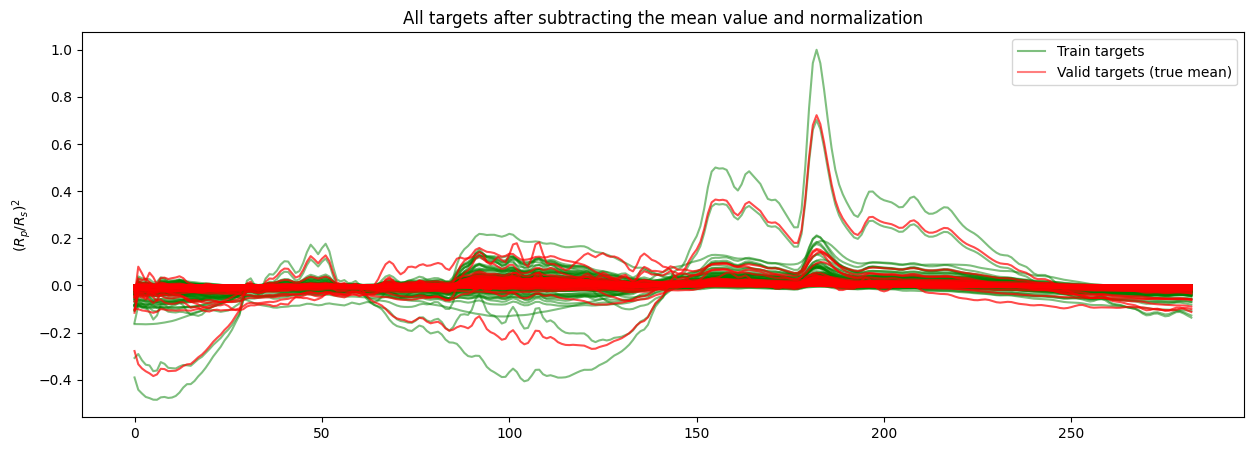

In [20]:
plt.figure(figsize=(15, 5))

for i in range(240):
    plt.plot(wls, train_targets_norm[i], "g-", alpha=0.5)
plt.plot([], [], "g-", alpha=0.5, label="Train targets")

for i in range(60):
    plt.plot(wls, valid_targets_norm[i], "r-", alpha=0.7)
plt.plot([], [], "r-", alpha=0.5, label="Valid targets (true mean)") # TODO: what is this?

plt.legend()
plt.ylabel(f"$(R_p/R_s)^2$")
plt.title("All targets after subtracting the mean value and normalization")
plt.show()

In [21]:
###### Transpose #####
train_obs = train_obs.transpose(0, 2, 1)
valid_obs = valid_obs.transpose(0, 2, 1)
print(train_obs.shape)

(538, 187, 283)


We cut the transit to keep the in-transit. We assume an arbitrary transit duration of 40 instants with a transit occuring between 75 and 115.

In [22]:
##### Subtracting the out transit signal #####
def suppress_out_transit(data, ingress, egress):
    data_in = data[:, ingress:egress, :]
    return data_in


ingress, egress = 75, 115
train_obs_in = suppress_out_transit(train_obs, ingress, egress)
valid_obs_in = suppress_out_transit(valid_obs, ingress, egress)

print("train_obs_in.shape", train_obs_in.shape)
print("valid_obs_in.shape", valid_obs_in.shape)

train_obs_in.shape (538, 40, 283)
valid_obs_in.shape (135, 40, 283)


We remove the mean value of the in-transit to get relative data like the targets

In [23]:
###### Subtract the mean #####
def subtract_data_mean(data):
    data_mean = np.zeros(data.shape)
    for i in range(data.shape[0]):
        data_mean[i] = data[i] - data[i].mean()
    return data_mean


train_obs_2d_mean = subtract_data_mean(train_obs_in)
valid_obs_2d_mean = subtract_data_mean(valid_obs_in)

print("train_obs_2d_mean.shape", train_obs_2d_mean.shape)
print("valid_obs_2d_mean.shape", valid_obs_2d_mean.shape)

train_obs_2d_mean.shape (538, 40, 283)
valid_obs_2d_mean.shape (135, 40, 283)


We use the same normalization as for the targets, i.e. between -1 and 1 centered on zero

In [24]:
##### Normalization dataset #####
data_normalization = targets_normalization


# TODO: this function is not used
def data_normback(data, data_abs_max):
    return data * data_abs_max


train_obs_norm, valid_obs_norm, data_abs_max = data_normalization(
    train_obs_2d_mean, valid_obs_2d_mean
)

print("train_obs_norm.shape", train_obs_norm.shape)
print("valid_obs_norm.shape", valid_obs_norm.shape)

train_obs_norm.shape (538, 40, 283)
valid_obs_norm.shape (135, 40, 283)


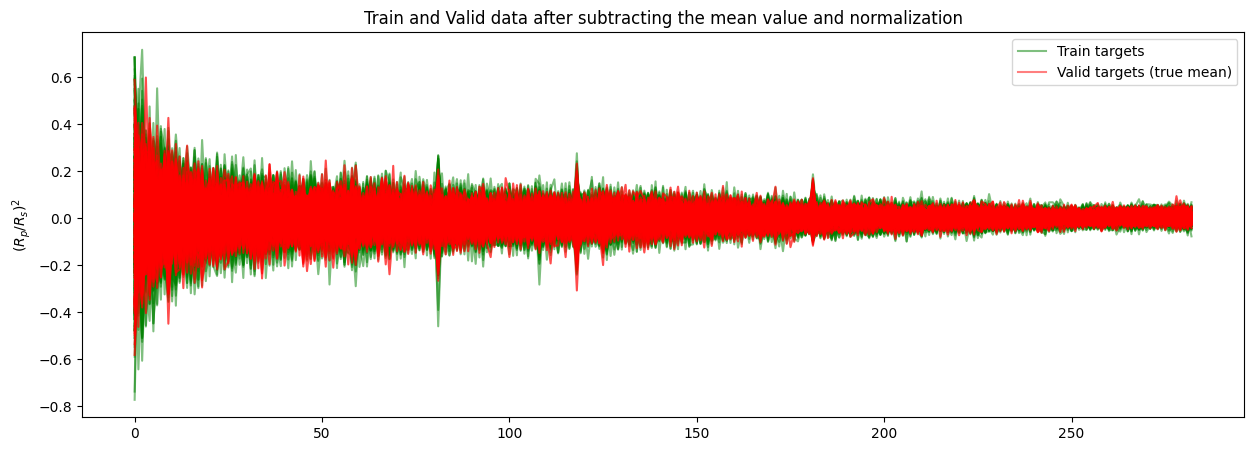

In [25]:
plt.figure(figsize=(15, 5))

for i in range(train_obs.shape[0]):
    plt.plot(wls, train_obs_norm[i, 10], "g-", alpha=0.5)
plt.plot([], [], "g-", alpha=0.5, label="Train targets")

for i in range(valid_obs.shape[0]):
    plt.plot(wls, valid_obs_norm[i, 10], "r-", alpha=0.7)
plt.plot([], [], "r-", alpha=0.5, label="Valid targets (true mean)")

plt.legend()
plt.ylabel(f"$(R_p/R_s)^2$")
plt.title("Train and Valid data after subtracting the mean value and normalization")
plt.show()

## Train 2D CNN

In [26]:
class CNN2DModel(nn.Module):
    def __init__(self):
        super(CNN2DModel, self).__init__()

        # Define the convolutional layers
        self.conv_2d_1 = nn.Conv2d(
            in_channels=1, out_channels=32, kernel_size=(3, 1), padding="same"
        )
        self.conv_2d_2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=(3, 1), padding="same"
        )
        self.conv_2d_3 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=(3, 1), padding="same"
        )
        self.conv_2d_4 = nn.Conv2d(
            in_channels=128, out_channels=256, kernel_size=(3, 1), padding="same"
        )
        self.conv_2d_5 = nn.Conv2d(
            in_channels=256, out_channels=32, kernel_size=(1, 3), padding="same"
        )
        self.conv_2d_6 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=(1, 3), padding="same"
        )
        self.conv_2d_7 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=(1, 3), padding="same"
        )
        self.conv_2d_8 = nn.Conv2d(
            in_channels=128, out_channels=256, kernel_size=(1, 3), padding="same"
        )

        # Define pooling and batch normalization layers
        self.pool_2d_1 = nn.MaxPool2d(kernel_size=(2, 1))
        self.pool_2d_2 = nn.MaxPool2d(kernel_size=(1, 2))
        self.bn_2d_1 = nn.BatchNorm2d(num_features=32)
        self.bn_2d_2 = nn.BatchNorm2d(num_features=32)

        self.flatten = nn.Flatten()

        # Define fully connected layers
        self.fc_1 = nn.Linear(in_features=256 * 5 * 17, out_features=700)
        self.fc_2 = nn.Linear(in_features=700, out_features=283)

        # Dropout
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.conv_2d_1(x))
        x = self.pool_2d_1(x)
        x = self.bn_2d_1(x)

        x = F.relu(self.conv_2d_2(x))
        x = self.pool_2d_1(x)

        x = F.relu(self.conv_2d_3(x))
        x = self.pool_2d_1(x)

        x = F.relu(self.conv_2d_4(x))

        x = F.relu(self.conv_2d_5(x))
        x = self.pool_2d_2(x)
        x = self.bn_2d_2(x)

        x = F.relu(self.conv_2d_6(x))
        x = self.pool_2d_2(x)

        x = F.relu(self.conv_2d_7(x))
        x = self.pool_2d_2(x)

        x = F.relu(self.conv_2d_8(x))
        x = self.pool_2d_2(x)

        x = self.flatten(x)

        x = F.relu(self.fc_1(x))
        x = self.dropout(x)

        x = self.fc_2(x)

        return x

In [27]:
# define 2D model hyperparameters
num_epochs_2D = 200
batch_size_2D = 32

model_2D = CNN2DModel().to(device)

criterion_2D = nn.MSELoss()

optimizer_2D = optim.Adam(model_2D.parameters(), lr=0.001)

best_valid_loss_2D = float("inf")

# compare pytorch data with Tensorflow data
compare_tf_data_with_current_data(
    train_obs_norm, np.load("../output/data_tf/train_obs_norm.npy"), "train_obs_norm"
)
compare_tf_data_with_current_data(
    train_targets_norm,
    np.load("../output/data_tf/train_targets_norm.npy"),
    "train_targets_norm",
)
compare_tf_data_with_current_data(
    valid_obs_norm, np.load("../output/data_tf/valid_obs_norm.npy"), "valid_obs_norm"
)
compare_tf_data_with_current_data(
    valid_targets_norm,
    np.load("../output/data_tf/valid_targets_norm.npy"),
    "valid_targets_norm",
)

# Dataset and Dataloader
train_dataset_2D = TensorDataset(
    torch.tensor(train_obs_norm[:, np.newaxis, :, :], dtype=torch.float32),
    torch.tensor(train_targets_norm, dtype=torch.float32),
)
valid_dataset_2D = TensorDataset(
    torch.tensor(valid_obs_norm[:, np.newaxis, :, :], dtype=torch.float32),
    torch.tensor(valid_targets_norm, dtype=torch.float32),
)

train_loader_2D = DataLoader(train_dataset_2D, batch_size=batch_size_2D, shuffle=True)
valid_loader_2D = DataLoader(valid_dataset_2D, batch_size=batch_size_2D, shuffle=False)

print("train input: ", train_loader_2D.dataset.tensors[0].shape)
print("train output: ", train_loader_2D.dataset.tensors[1].shape)
print("valid input: ", valid_loader_2D.dataset.tensors[0].shape)
print("valid output: ", valid_loader_2D.dataset.tensors[1].shape)

summary(model_2D, input_size=(train_loader_2D.dataset.tensors[0].shape))

train_obs_norm :  True
train_targets_norm :  True
valid_obs_norm :  True
valid_targets_norm :  True
train input:  torch.Size([538, 1, 40, 283])
train output:  torch.Size([538, 283])
valid input:  torch.Size([135, 1, 40, 283])
valid output:  torch.Size([135, 283])


Layer (type:depth-idx)                   Output Shape              Param #
CNN2DModel                               [538, 283]                --
├─Conv2d: 1-1                            [538, 32, 40, 283]        128
├─MaxPool2d: 1-2                         [538, 32, 20, 283]        --
├─BatchNorm2d: 1-3                       [538, 32, 20, 283]        64
├─Conv2d: 1-4                            [538, 64, 20, 283]        6,208
├─MaxPool2d: 1-5                         [538, 64, 10, 283]        --
├─Conv2d: 1-6                            [538, 128, 10, 283]       24,704
├─MaxPool2d: 1-7                         [538, 128, 5, 283]        --
├─Conv2d: 1-8                            [538, 256, 5, 283]        98,560
├─Conv2d: 1-9                            [538, 32, 5, 283]         24,608
├─MaxPool2d: 1-10                        [538, 32, 5, 141]         --
├─BatchNorm2d: 1-11                      [538, 32, 5, 141]         64
├─Conv2d: 1-12                           [538, 64, 5, 141]         6,

In [ ]:
train_losses_2D, valid_losses_2D = train(
    model=model_2D,
    train_loader=train_loader_2D,
    valid_loader=valid_loader_2D,
    num_epochs=num_epochs_2D,
    criterion=criterion_2D,
    optimizer=optimizer_2D,
    scheduler=None,
    output_dir=output_dir + "/2D",
    device=device,
    best_valid_loss=best_valid_loss_2D,
)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs_2D + 1), train_losses_2D, label="Training Loss 2D")
plt.plot(range(1, num_epochs_2D + 1), valid_losses_2D, label="Validation Loss 2D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (2D)")
plt.legend()
plt.grid(True)

plt.savefig(output_dir + "/2D" + "/training_validation_loss.png")
plt.show()

print("training loss 2D: ", max(train_losses_2D), min(train_losses_2D))
print("validation loss 2D: ", max(valid_losses_2D), min(valid_losses_2D))

In [28]:
model_2D, optimizer_2D, num_epochs_2D, best_valid_loss_2D = load_checkpoint(
    output_dir + "/2D", model_2D, optimizer_2D
)

Checkpoint loaded: Epoch 148, Validation Loss 0.0001


## Postprocessing and visualisation

We obtain uncertainties on the predictions by computing a MCDropout.

In [29]:
nb_dropout = 5


def NN_uncertainty(model, x_test, targets_abs_max, nb_dropout, device):
    model.eval()
    all_predictions = []

    for _ in range(nb_dropout):

        batch_predictions = []
        with torch.no_grad():
            for x_valid, _ in x_test:

                pred_norm = model(x_valid.to(device))
                pred = pred_norm * targets_abs_max

                batch_predictions.append(pred.cpu().numpy())

        all_predictions.append(np.concatenate(batch_predictions, axis=0))

    all_predictions = np.array(all_predictions)

    mean = np.mean(all_predictions, axis=0)
    std = np.std(all_predictions, axis=0)

    return mean, std


if do_the_mcdropout:
    spectre_valid_shift, spectre_valid_shift_std = NN_uncertainty(
        model_2D, valid_loader_2D, targets_abs_max, nb_dropout, device
    )

In [30]:
residuals = valid_targets_shift - spectre_valid_shift
print("MSE : ", np.sqrt((residuals**2).mean()) * 1e6, "ppm")

MSE :  33.60906180930864 ppm


In [31]:
# np.save(f'{output_dir}/pred_valid_shift.npy', spectre_valid_shift)
# np.save(f'{output_dir}/targ_valid_shift.npy', valid_targets_shift)
# np.save(f'{output_dir}/std_valid_shift.npy', spectre_valid_shift_std)

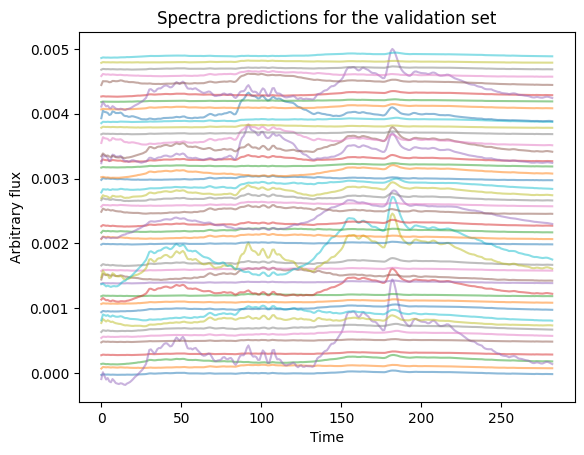

In [32]:
plt.figure()
for i in range(50):
    plt.plot(spectre_valid_shift[-i] + 0.0001 * i, "-", alpha=0.5)
plt.title("Spectra predictions for the validation set")
plt.xlabel("Time")
plt.ylabel("Arbitrary flux")
plt.show()

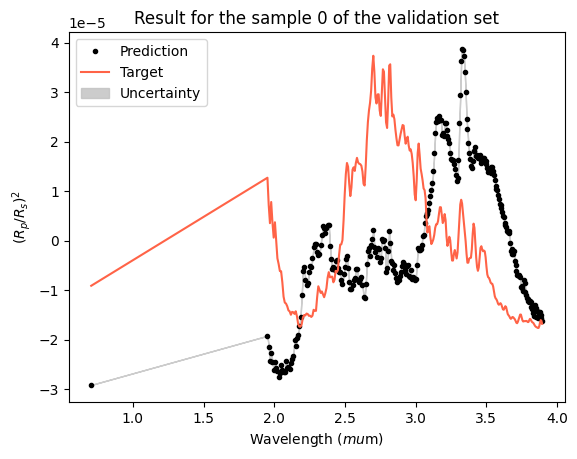

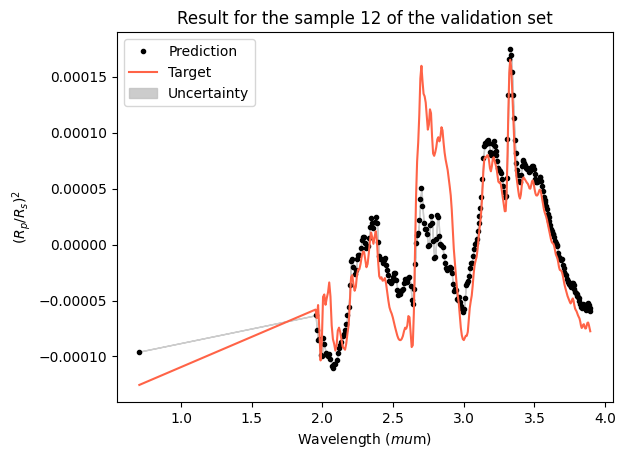

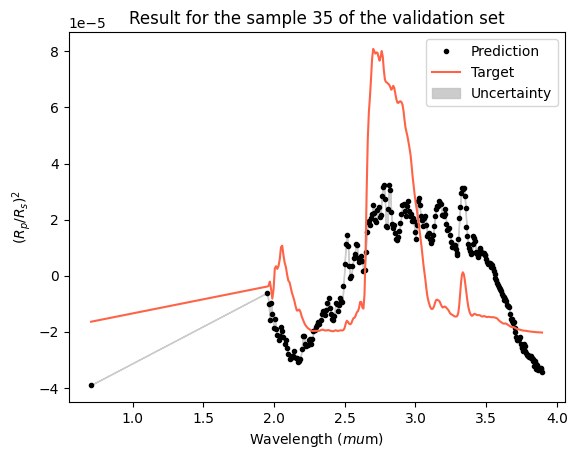

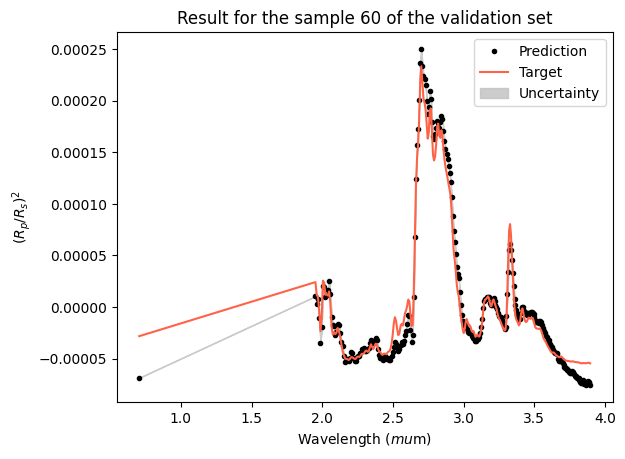

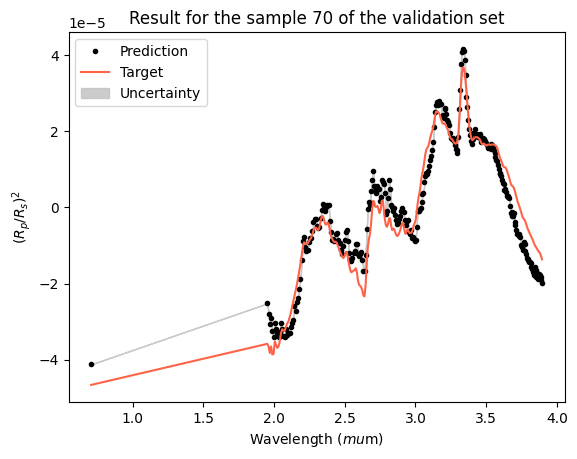

In [33]:
list_valid_planets = [0, 12, 35, 60, 70]
wavelength = np.loadtxt(
    "../dataset/ariel-data-challenge-2024/wavelengths.csv", skiprows=1, delimiter=","
)
uncertainty = spectre_valid_shift_std
for i in list_valid_planets:
    plt.figure()
    plt.title("Result for the sample {} of the validation set".format(i))
    plt.plot(wavelength, spectre_valid_shift[i], ".k", label="Prediction")
    plt.plot(wavelength, valid_targets_shift[i], color="tomato", label="Target")
    plt.fill_between(
        wavelength,
        spectre_valid_shift[i] - spectre_valid_shift_std[i],
        spectre_valid_shift[i] + spectre_valid_shift_std[i],
        color="silver",
        alpha=0.8,
        label="Uncertainty",
    )
    plt.legend()
    plt.ylabel(f"$(R_p/R_s)^2$")
    plt.xlabel(f"Wavelength ($mu$m)")
    plt.show()

# Combine 1D and 2D CNN output for FINAL SPECTRA 

In [34]:
######## ADD THE FLUCTUATIONS TO THE MEAN ########
def add_the_mean(shift, mean):
    return shift + mean[:, np.newaxis]


predictions_valid = add_the_mean(spectre_valid_shift, spectre_valid_wc)

predictions_std_valid = np.sqrt(
    spectre_valid_std_wc[:, np.newaxis] ** 2 + spectre_valid_shift_std**2
)

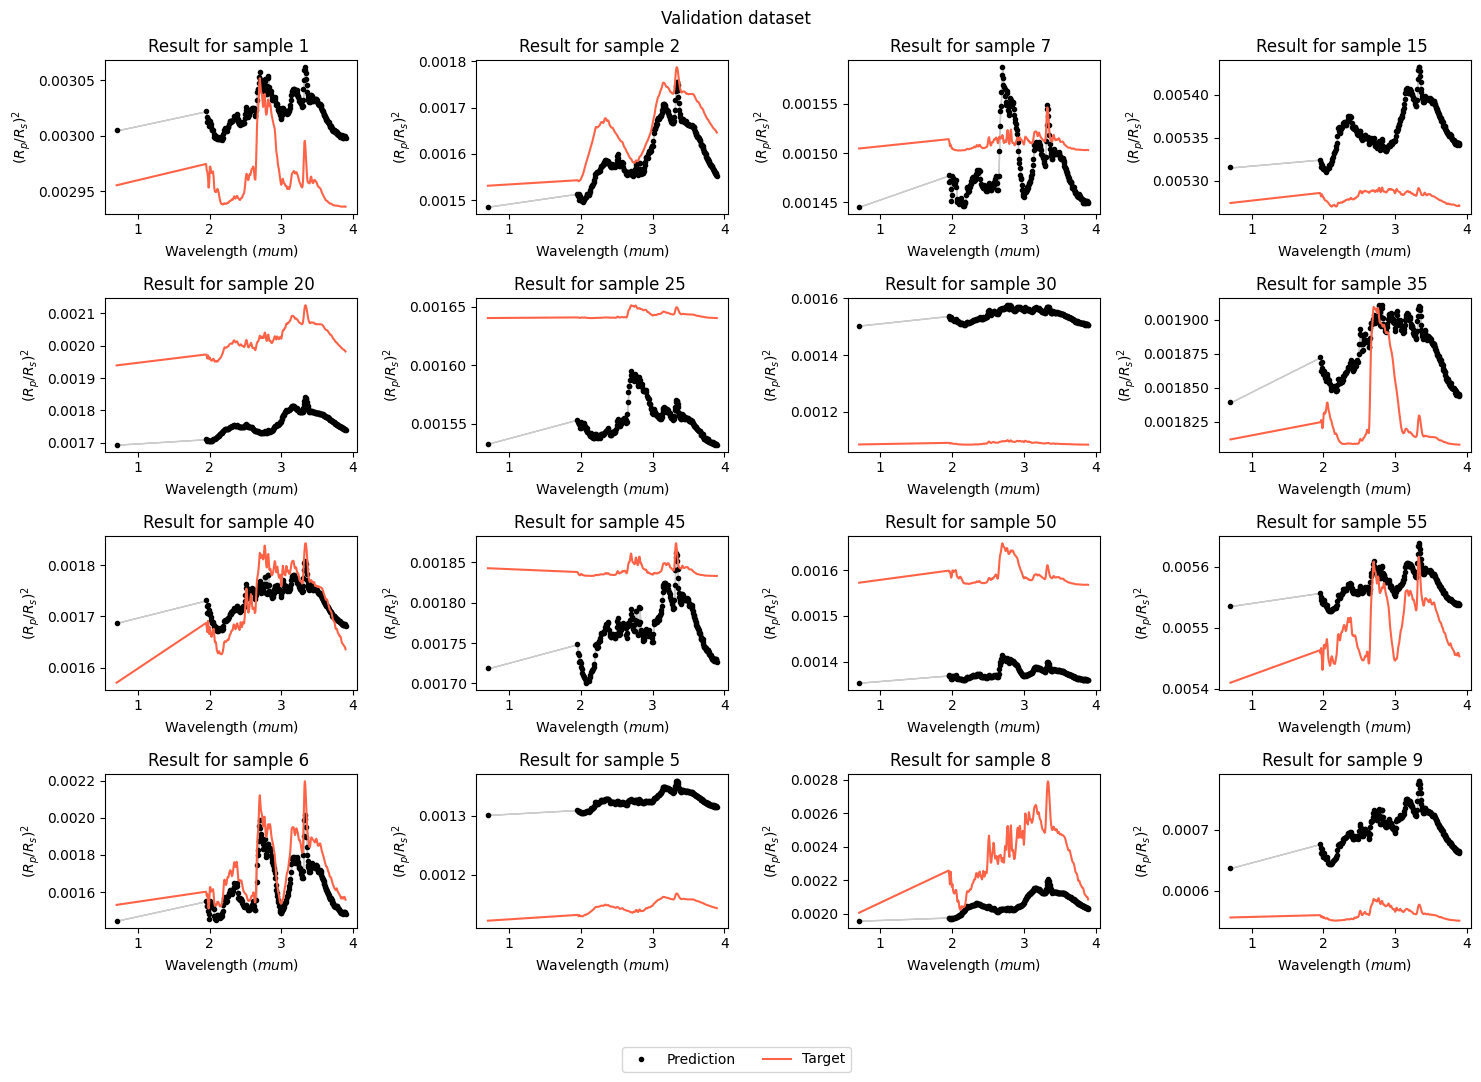

In [35]:
uncertainty = predictions_std_valid


def plot_one_sample_valid(ax, p):
    ax.set_title(f"Result for sample {p} ")
    (line1,) = ax.plot(wavelength, predictions_valid[p], ".k", label="Prediction")
    (line2,) = ax.plot(wavelength, valid_targets[p], color="tomato", label="Target")
    ax.fill_between(
        wavelength,
        predictions_valid[p, :] - uncertainty[p],
        predictions_valid[p, :] + uncertainty[p],
        color="silver",
        alpha=0.8,
        label="Uncertainty",
    )
    ax.set_ylabel(f"$(R_p/R_s)^2$")
    ax.set_xlabel(f"Wavelength ($mu$m)")
    return line1, line2


num_samples = 16
rows, cols = 4, 4

fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
samples = [1, 2, 7, 15, 20, 25, 30, 35, 40, 45, 50, 55, 6, 5, 8, 9]
lines = []

for i, ax in enumerate(axs.flat):
    lines.extend(plot_one_sample_valid(ax, samples[i]))

fig.legend(
    lines[:2],
    ["Prediction", "Target"],
    loc="upper center",
    ncol=3,
    bbox_to_anchor=(0.5, -0.05),
)
fig.suptitle("Validation dataset")
plt.tight_layout()
plt.show()

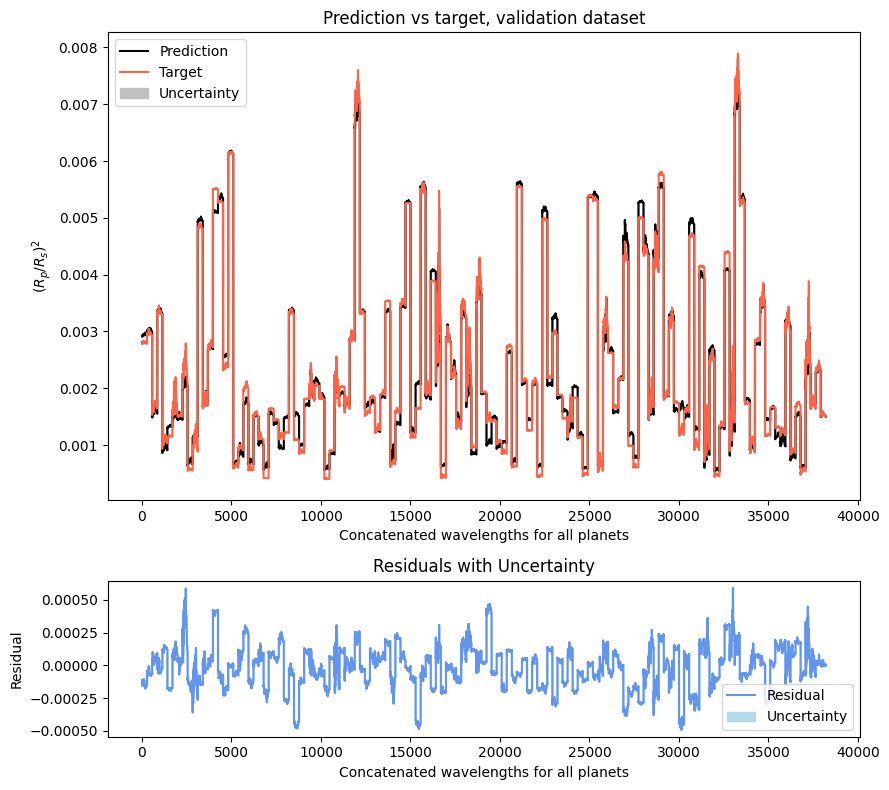

MSE :  161.1619283377408 ppm


In [36]:
######## PLOTS THE RESULT ########
predictions = predictions_valid
targets_plot = valid_targets
std = predictions_std_valid

predictions_concatenated_plot = np.concatenate(predictions, axis=0)
wls_concatenated = np.arange(predictions_concatenated_plot.shape[0])
targets_concatenated_plot = np.concatenate(targets_plot, axis=0)
spectre_valid_std_concatenated = np.concatenate(std, axis=0)
residuals = targets_concatenated_plot - predictions_concatenated_plot
uncertainty = spectre_valid_std_concatenated

fig, axs = plt.subplots(2, 1, figsize=(9, 8), gridspec_kw={"height_ratios": [3, 1]})


axs[0].plot(
    wls_concatenated, predictions_concatenated_plot, "-", color="k", label="Prediction"
)
axs[0].plot(
    wls_concatenated, targets_concatenated_plot, "-", color="tomato", label="Target"
)
axs[0].fill_between(
    np.arange(len(wls_concatenated)),
    predictions_concatenated_plot - uncertainty,
    predictions_concatenated_plot + uncertainty,
    color="silver",
    alpha=1,
    label="Uncertainty",
)
axs[0].set_xlabel("Concatenated wavelengths for all planets")
axs[0].set_ylabel(f"$(R_p/R_s)^2$")
axs[0].set_title("Prediction vs target, validation dataset")
axs[0].legend()

axs[1].plot(wls_concatenated, residuals, "-", color="cornflowerblue", label="Residual")
axs[1].fill_between(
    np.arange(len(wls_concatenated)),
    residuals - uncertainty,
    residuals + uncertainty,
    color="lightblue",
    alpha=0.9,
    label="Uncertainty",
)
axs[1].set_xlabel("Concatenated wavelengths for all planets")
axs[1].set_ylabel("Residual")
axs[1].set_title("Residuals with Uncertainty")
axs[1].legend()

plt.tight_layout()
plt.show()

print("MSE : ", np.sqrt((residuals**2).mean()) * 1e6, "ppm")

In [37]:
# np.save(f'{output_dir}/pred_valid.npy', predictions_valid)
# np.save(f'{output_dir}/std_valid.npy', predictions_std_valid)